<a href="https://colab.research.google.com/github/AvantiShri/oceanography_colab_notebooks/blob/master/for_rian/ConstrainedWaterMassAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cvxpy as cp

In [3]:
!pip install gsw

     |████████████████████████████████| 2.4MB 2.7MB/s 


In [4]:
import gsw



In [5]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2020-10-07 19:07:13--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 108.177.125.139, 108.177.125.101, 108.177.125.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c4alv08cgohvnftftq9ksp923qaq9q1q/1602097575000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2020-10-07 19:07:14--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c4alv08cgohvnftftq9ksp923qaq9q1q/1602097575000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-

In [6]:
def augment_df_with_PO_NO_SiO(df):  
  #remineralization ratios
  r_PO = 155;
  r_SiO = 15
  r_NO = 9.68
  df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
  df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
  df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO

In [92]:
import pandas as pd
import numpy as np

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "slicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "latitude"
header[9] = "longitude"

header[0] = "stnnbr"
header[4] = "btl_flag"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["longitude"],
                                   lat=gp15_df["latitude"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sig0"] = sig0
sig1500 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=1500) - 1000
sig2000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=2000) - 1000
sig3000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=3000) - 1000
sig4000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=4000) - 1000

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["latitude"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["latitude"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

gp15_df["mass"] = 1

Rows: 1143
Rows without NA values: 1124


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1069: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [93]:
# Next, define the end members for the intermediate OMPA and deep OMPA.
# Each row represents the hydrographic definitions of each water mass.
# The columns of data are the parameters listed here:
#
# [ temperature ; salinity ; oxygen ; phosphate ; silicate ;
#   nitrate; spiciness; vorticity]
#

def prepare_water_mass_df(water_mass_arr):
    df = pd.DataFrame(data=water_mass_arr,
                      columns=["watermassname",
                               "potential_temp", "practical_salinity",
                               "oxygen", "phosphate", "silicate",
                               "nitrate", "spiciness", "PV"])
    augment_df_with_PO_NO_SiO(df)
    df["mass"] = 1
    return df

                             #Temp  Sal     Oxy     Phos   Sili   Nitr    Spic      Vort
P16_Emilie_AAIW = ["AAIW",    5.68, 34.307, 237.0,  1.77,  16.60, 25.5,   0.068,    88.86E-12]
GLODAP_mystery =  ["Mystery", 2.09, 34.53,   36.1,  3.03, 168.87, 43.5,  -0.154,    26.95E-12]
GLODAP_NPIW =     ["NPIW",    4.72, 34,      81.8,  2.64,  79.87, 36.48, -0.262,   130.26E-12]
GLODAP_EqPIW =    ["EqPIW",   7.65, 34.60,   48.50, 2.71,  44.53, 38.26,  0.568,     0.01E-12]
P16_UCDW =        ["UCDW",    2.6,  34.575, 168,    2.4,   85.7,  34.4,  -0.1,      37.49E-12]
Emilie_P16_PDW =  ["PDW",     1.65, 34.641,	95,	   2.77, 175.9,	 40.1,  -0.123,    10.43E-12]
P16_LCDW =        ["LCDW",    1.62, 34.738, 195,    2.17,  96.6,  31,    -0.066,    12.55E-12]
GLODAP_AABW =     ["AABW",    0.18, 34.70,  219,    2.27, 124.45, 32.57, -0.203,     2.9E-12]

end_mem_intanddeep_df = prepare_water_mass_df(
    [P16_Emilie_AAIW,
     GLODAP_mystery,
     GLODAP_NPIW,
     GLODAP_EqPIW,
     P16_UCDW,
     Emilie_P16_PDW,
     P16_LCDW,
     GLODAP_AABW])

# Now, the end member definitions for the water masses now include the following parameters:
#  0      1      2      3       4      5      6     7     8      9       10
# [temp ; sal ; [O2] ; [PO4] ; [Si] ; [NO3] ; Spic; Vort; 'PO' ; 'SiO' ; 'NO' ]

In [94]:
max(gp15_df[(gp15_df["sig0"] <= 27.72)]["depth"])

2401.1070865746165

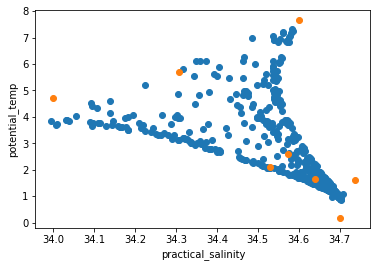

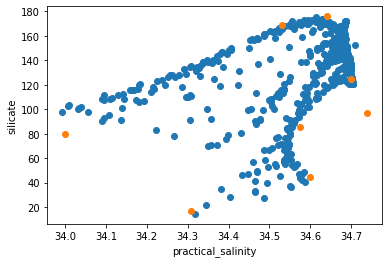

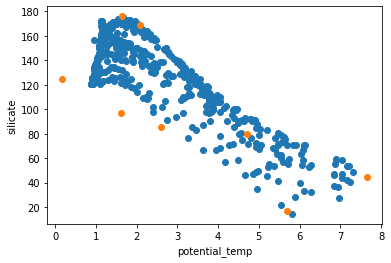

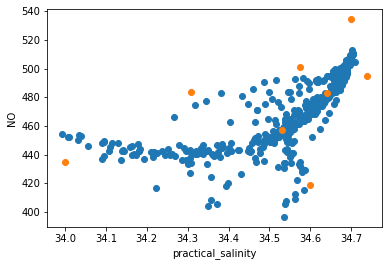

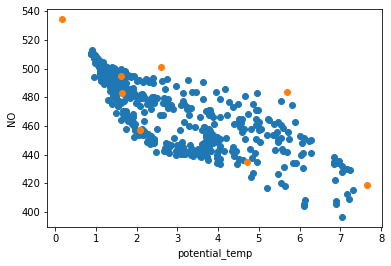

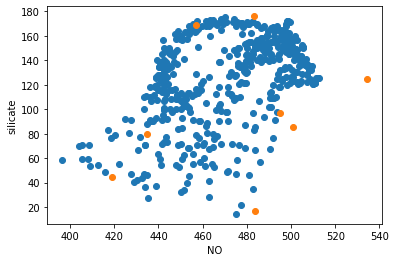

In [95]:
from matplotlib import pyplot as plt

#Make plots of intermedaite and deep waters
# to sanity-check

#Constrain to intermediate waters
# For intermedaite, also have (gp15_df["sig0"] <= 27.72)
gp15_intanddeep_df = gp15_df[(gp15_df["sig0"] >= 27.0)]

def plot_intanddeep(xaxis, yaxis):
  plt.scatter(gp15_intanddeep_df[xaxis],
              gp15_intanddeep_df[yaxis])
  plt.scatter(end_mem_intanddeep_df[xaxis],
              end_mem_intanddeep_df[yaxis])
  plt.xlabel(xaxis)
  plt.ylabel(yaxis)
  plt.show()

plot_intanddeep("practical_salinity", "potential_temp")
plot_intanddeep("practical_salinity", "silicate")
plot_intanddeep("potential_temp", "silicate")
plot_intanddeep("practical_salinity", "NO")
plot_intanddeep("potential_temp", "NO")
plot_intanddeep("NO", "silicate")

In [154]:


def perform_OMPA(df_for_A, df_for_obs, params_to_use, weighting,
                 enforce_mass_conservation):
    #We are going to solve the following problem:
    # Minimize (x A - b)^2
    # Subject to x >= 0, x <= 1, cp.sum(x, axis=1) == 1
    # x has dimensions of observations X end_members
    # A has dimensions of end_members X parameteres
    # b has dimensions of observations X parameters

    #We also want a matrix that is [pairs X observations]

    A = np.array(df_for_A[params_to_use])
    b = np.array(df_for_obs[params_to_use])

    #compute the variance of the parameters
    #param_variances = np.nanvar(b, axis=0)
    #apply a relative weighting
    #weighting = (1/param_variances)*relative_weighting
    weighting = weighting
    print("params to use:", params_to_use)
    print("param weighting:", weighting)

    A = A*weighting[None,:]
    b = b*weighting[None,:]

    x = cp.Variable(shape=(len(b), len(A)))
    obj = cp.Minimize(cp.sum_squares(x@A - b))
    constraints = [x >= 0]
    if (enforce_mass_conservation):
        constraints.append(cp.sum(x,axis=1)==1)
    prob = cp.Problem(obj, constraints)
    prob.solve()  # Returns the optimal value.
    print("status:", prob.status)
    print("optimal value", prob.value)

    reconstruction = (x.value@A)/weighting[None,:]
    residuals = b/weighting[None,:] - reconstruction

    return x.value, reconstruction, residuals

end_mem_intermediate_df = prepare_water_mass_df(
    [P16_Emilie_AAIW,
     #GLODAP_mystery,
     GLODAP_NPIW,
     GLODAP_EqPIW,
     P16_UCDW,
     Emilie_P16_PDW,
     #P16_LCDW,
     #GLODAP_AABW
     ])
gp15_intermediate = gp15_df[(gp15_df["sig0"] >= 27.0) & (gp15_df["sig0"] <= 27.72)]
#gp15_intermediate = gp15_df[(gp15_df["sig0"] >= 27.0)]
intermediate_params = ["potential_temp", "practical_salinity",
                         "silicate", "NO", "spiciness", "PV", "mass"]
intermediate_weighting = np.array([140, 100, 30, 10, 10, 10, 140])

int_fractions, int_reconstruction, int_residuals = perform_OMPA(
    df_for_A=end_mem_intermediate_df,
    df_for_obs=gp15_intermediate,
    params_to_use=intermediate_params,
    weighting=intermediate_weighting,
    enforce_mass_conservation=True)

params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'spiciness', 'PV', 'mass']
param weighting: [140 100  30  10  10  10 140]
status: optimal
optimal value 4443386.116435583


potential_temp


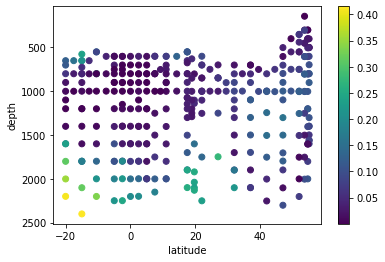

practical_salinity


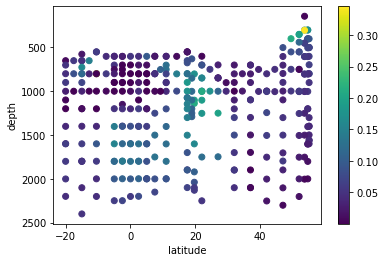

silicate


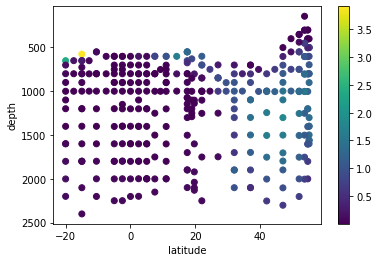

NO


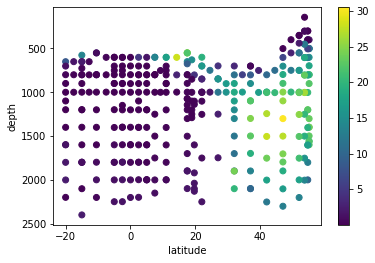

spiciness


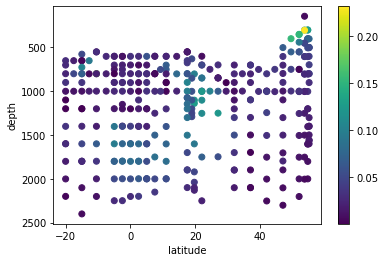

PV


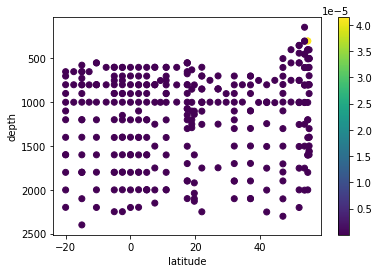

mass


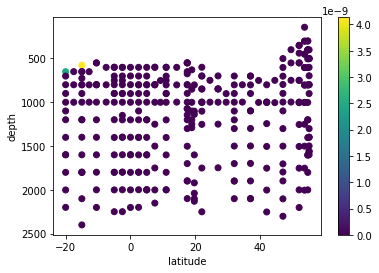

In [155]:

for i in range(int_residuals.shape[1]):
    print(intermediate_params[i])
    plt.scatter(x=gp15_intermediate["latitude"],
                    y=gp15_intermediate["depth"],
                    c=np.abs(int_residuals[:,i]),
                    cmap="viridis")
    plt.colorbar()
    plt.xlabel("latitude")
    plt.ylabel("depth")
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.show()

AAIW


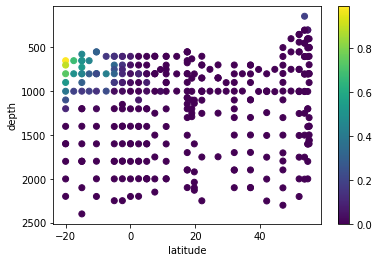

NPIW


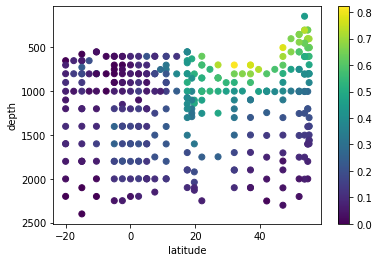

EqPIW


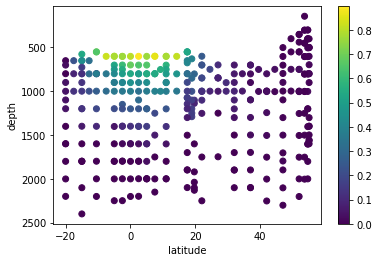

UCDW


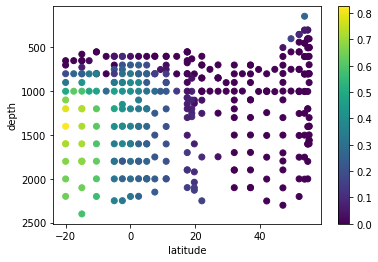

PDW


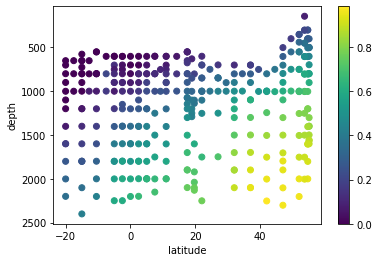

In [156]:
for i in range(int_fractions.shape[1]):
    print(end_mem_intermediate_df["watermassname"][i])
    plt.scatter(gp15_intermediate["latitude"],
                gp15_intermediate["depth"],
                c=int_fractions[:,i])
    plt.xlabel("latitude")
    plt.ylabel("depth")
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.colorbar()
    plt.show()